In [1]:
# imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Imposta il device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
class ApplyThreshold:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def __call__(self, tensor):
        # Applica la thresholding: valori >= threshold diventano 1, altri diventano 0
        return (tensor >= self.threshold).float()

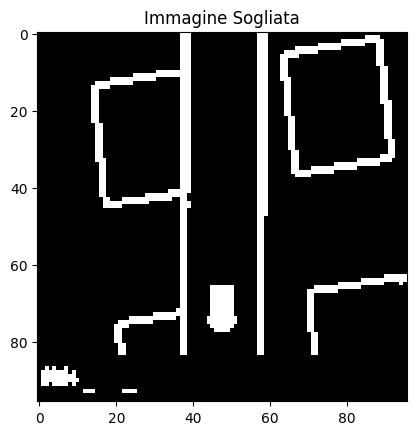

In [4]:
from PIL import Image

# Carica l'immagine
img = Image.open("./test_edges/0/0000.png").convert("L")  # Converte in scala di grigi

# Converti l'immagine in tensore
transform_to_tensor = transforms.ToTensor()
img = transform_to_tensor(img)

# Applica la threshold
img = (img >= 0.1).float()

# Rimuovi il canale in eccesso per plt.imshow
plt.imshow(img.squeeze(), cmap="gray")
plt.title("Immagine Sogliata")
plt.show()

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Percorso del dataset (immagini preprocessate con data augmentation)
dataset_dir = "./train_balanced_augmented_edges"

# Trasformazioni: Normalizzazione e Preprocessing finale
transform = transforms.Compose([
    #transforms.Resize((96, 96)),  # Assicura dimensioni coerenti
    transforms.Grayscale(),
    transforms.ToTensor(),  # Conversione a tensore
    ApplyThreshold(threshold=0.1),
])

In [6]:
# Creazione del Dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Suddivisione Train/Test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Controllo rapido
print(f"Numero di immagini nel train set: {len(train_dataset)}")
print(f"Numero di immagini nel test set: {len(test_dataset)}")
print(f"Classi disponibili: {dataset.classes}")

Numero di immagini nel train set: 2952
Numero di immagini nel test set: 738
Classi disponibili: ['0', '1', '2', '3', '4']


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Section
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2), 

            nn.Conv2d(16, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   
        )

        # Fully Connected Section
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(24 * 24 * 24, 512),  # Fully connected
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # Fully connected
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Fully connected
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 5) # 5 classi di output
            
        )

    def forward(self, x):
        x = self.network(x)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)


In [8]:
# Funzione di loss con pesi bilanciati
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) 

# Loop di training
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
    
    accuracy = 100 * correct / len(loader.dataset)
    return running_loss / len(loader), accuracy

In [9]:
def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return y_true, y_pred

In [10]:
num_epochs = 6

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

Epoch 1/6: Loss: 1.7109, Accuracy: 20.97%
Epoch 2/6: Loss: 1.6111, Accuracy: 21.44%
Epoch 3/6: Loss: 1.5839, Accuracy: 25.20%
Epoch 4/6: Loss: 1.5357, Accuracy: 30.72%
Epoch 5/6: Loss: 1.5203, Accuracy: 29.44%
Epoch 6/6: Loss: 1.4958, Accuracy: 30.79%


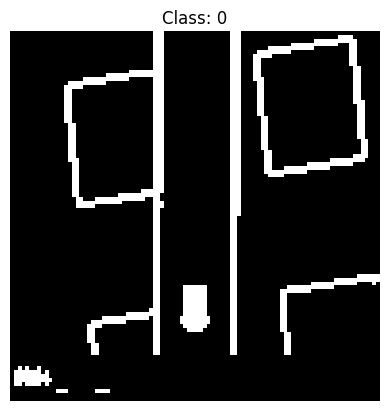

In [13]:
test_transform = transforms.Compose([
    #transforms.Resize((96, 96)),  # Assicura dimensioni coerenti
    transforms.Grayscale(),
    transforms.ToTensor(),  # Conversione a tensore
    ApplyThreshold(threshold=0.1),
])

test_set = ImageFolder(root='./test_edges', transform=test_transform)

# Carica il primo elemento dal dataset
image_tensor, label = test_set[0]  # Prendi il primo elemento trasformato

# Se l'immagine ha 1 canale (bianco e nero) usa cmap="gray"
# Se ha 3 canali (RGB), mantieni la rappresentazione RGB
if image_tensor.shape[0] == 1:
    # Semplice immagine in scala di grigi
    plt.imshow(image_tensor.squeeze(), cmap="gray")  # Rimuovi canale e usa cmap gray
else:
    # Immagine a 3 canali
    plt.imshow(image_tensor.permute(1, 2, 0))  # Cambia la forma da (C, H, W) a (H, W, C)
    
plt.title(f"Class: {label}")
plt.axis('off')  # Rimuovi gli assi
plt.show()



In [14]:
test_set_loader = DataLoader(test_set, batch_size=32, shuffle=False)

y_true, y_pred = evaluate(model, test_set_loader)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.02      0.02       133
           1       0.06      0.12      0.08       275
           2       0.10      0.19      0.13       406
           3       0.83      0.58      0.69      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.44      2749
   macro avg       0.21      0.18      0.19      2749
weighted avg       0.60      0.44      0.50      2749



In [23]:
torch.save({
    'model': model,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_58.pth')